## Урок 2. Масштабирование признаков. Регуляризация. Стохастический градиентный спуск.

### Домашнее задание

1. Сгенерировать датасет при помощи `sklearn.datasets.make_regression` и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.
2. Модифицировать решение первого задания путем добавления $L_{2}$-регуляризации (в функцию, считающую MSE добавить норму весов, а в поправку нужно добавить производную для нормы вектора весов по весам) и сравнить результаты.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression

from  sklearn.linear_model import SGDClassifier , SGDRegressor

%matplotlib inline

In [2]:
# сгенерируем набор данных
data1, target, coef = datasets.make_regression(n_samples=1000, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 5, coef = True, random_state = 2)
data1[:,0] = data1[:,0]*10

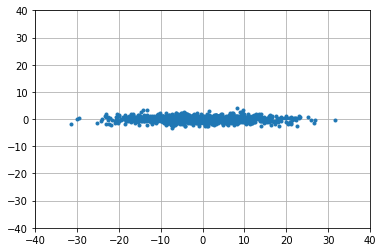

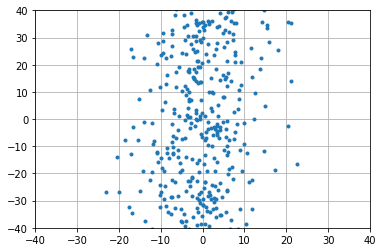

In [3]:
plt.plot(data1[:,0],data1[:,1], '.')
plt.xlim((-40,40))
plt.ylim((-40,40))
plt.grid(True)
plt.show()
plt.plot(data1[:,0],target, '.')
plt.xlim((-40,40))
plt.ylim((-40,40))
plt.grid(True)
plt.show()

In [4]:
# Получим средние значения и стандартное отклонение по столбцам
 
means = np.mean(data1, axis=0)
stds = np.std(data1, axis=0)
# параметр axis указывается для вычисления значений по столбцам, а не по всему массиву
#(см. документацию в разделе источников)
data = data1.copy() 
# вычтем каждое значение признака из среднего и поделим на стандартное отклонение
for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        data[i][j] = (data[i][j] - means[j])/stds[j]

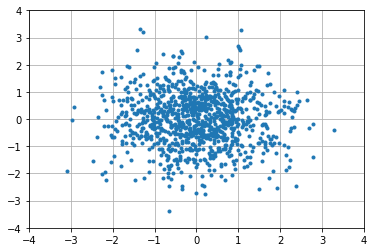

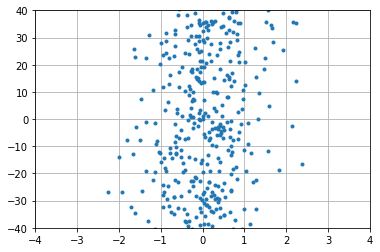

In [5]:
plt.plot(data[:,0],data[:,1], '.')
plt.xlim((-4,4))
plt.ylim((-4,4))
plt.grid(True)
plt.show()
plt.plot(data[:,0],target, '.')
plt.xlim((-4,4))
plt.ylim((-40,40))
plt.grid(True)
plt.show()

In [6]:
data1_test, target_test, _ = datasets.make_regression(n_samples=100, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 5, coef = True, random_state = 20)
data1_test[:,0] = data1_test[:,0]*10
data_test = data1_test.copy() 
# вычтем каждое значение признака из среднего и поделим на стандартное отклонение
for i in range(data1_test.shape[0]):
    for j in range(data1_test.shape[1]):
        data_test[i][j] = (data_test[i][j] - means[j])/stds[j]

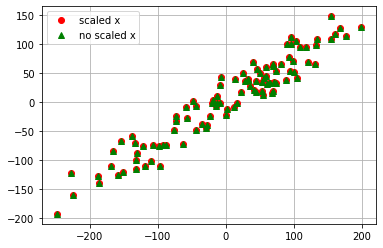

In [7]:
c_lr1 = LinearRegression().fit(data1,target)
c_lr = LinearRegression().fit(data,target)

y1 = c_lr1.predict(data1_test[:100,:])
y = c_lr.predict(data_test[:100,:])

plt.plot(y,target_test[:100],'or', label = 'scaled x')
plt.plot(y1,target_test[:100],'^g', label = 'no scaled x')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
e1 = np.mean(np.abs(y-target_test))
e = np.mean(np.abs(y1-target_test))
e,e1

(29.875665293256382, 29.875665293256375)

In [9]:
c_lr1.coef_, c_lr.coef_

(array([ 6.23314391, 68.27896744]), array([61.43607084, 67.66544978]))

In [10]:
# реализуем функцию, определяющую среднеквадратичную ошибку
def mserror(X, w, y_pred):
    y = X.dot(w)
    return (sum((y - y_pred)**2)) / len(y)

### Градиентный спуск

In [11]:
X = data1.copy()
w = coef.copy()
w_true = np.random.normal(size=(2, ))
Y = X.dot(w_true) + np.random.normal(0, 0.5, size=(1000))

In [12]:
# список векторов весов после каждой итерации
w_list = [w.copy()]

# список значений ошибок после каждой итерации
errors_GD = []

# шаг градиентного спуска
eta = 0.01

# максимальное число итераций
max_iter = 1e4

# критерий сходимости (разница весов, при которой алгоритм останавливается)
min_weight_dist = 1e-8

# зададим начальную разницу весов большим числом
weight_dist = np.inf

# счетчик итераций
iter_num = 0

# ход градиентного спуска
while weight_dist > min_weight_dist and iter_num < max_iter:
    new_w = w - 2 * eta * np.dot(X.T, (np.dot(X, w) - Y)) / Y.shape[0]
    weight_dist = np.linalg.norm(new_w - w, ord=2)
    
    w_list.append(new_w.copy())
    errors_GD.append(mserror(X, new_w, Y))
    
    iter_num += 1
    w = new_w
    
w_list = np.array(w_list)

print(f'В случае использования градиентного спуска функционал ошибки составляет {round(errors_GD[-1], 4)}')

В случае использования градиентного спуска функционал ошибки составляет 0.2471


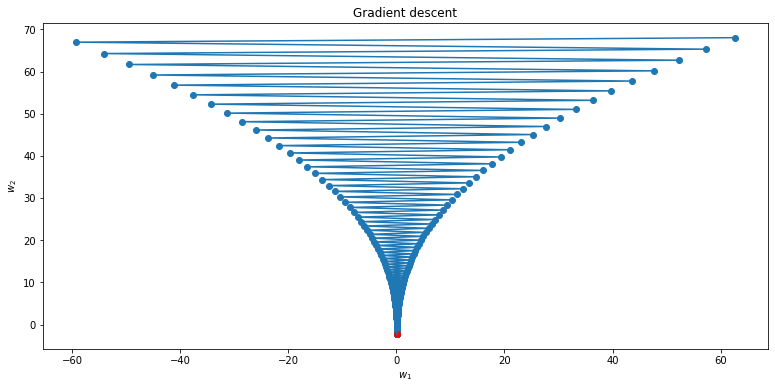

In [13]:
# Визуализируем изменение весов (красной точкой обозначены истинные веса, сгенерированные вначале)
plt.figure(figsize=(13, 6))
plt.title('Gradient descent')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')

plt.scatter(w_list[:, 0], w_list[:, 1])
plt.scatter(w_true[0], w_true[1], c='r')
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

### Стохастический градиентный спуск

In [14]:
# инициализируем начальный вектор весов
w = np.random.randn(2) # Это частный случай
 
# список векторов весов после каждой итерации
w_list = [w.copy()]
 
# список значений ошибок после каждой итерации
errors_SGD = []
 
# шаг градиентного спуска
eta = 0.15
 
# максимальное число итераций
max_iter = 1e5
 
# критерий сходимости (разница весов, при которой алгоритм останавливается)
min_weight_dist = 1e-8
 
# зададим начальную разницу весов большим числом
weight_dist = np.inf
 
# счетчик итераций
iter_num = 0
lamb = 0.01 
np.random.seed(1234)

Q = [0]  
# ход градиентного спуска
while weight_dist > min_weight_dist and iter_num < max_iter:
    
    # генерируем случайный индекс объекта выборки
    train_ind = np.random.randint(data.shape[0])
    
    new_w = w - 2 * eta * np.dot(data[train_ind].T, (np.dot(data[train_ind], w) - target[train_ind])) / target.shape[0]
 
    weight_dist = np.linalg.norm(new_w - w, ord=2)
    
    w_list.append(new_w.copy())
    errors_SGD.append(mserror(data, new_w, target))
    Q.append(Q[-1]*(1-lamb)+lamb*(np.dot(data[train_ind], w) - target[train_ind])**2)
    iter_num += 1
    w = new_w
    
w_list = np.array(w_list)
 
print(f'В случае использования стохастического градиентного спуска функционал ошибки составляет {round(errors_SGD[-1], 4)}')

В случае использования стохастического градиентного спуска функционал ошибки составляет 38.5809


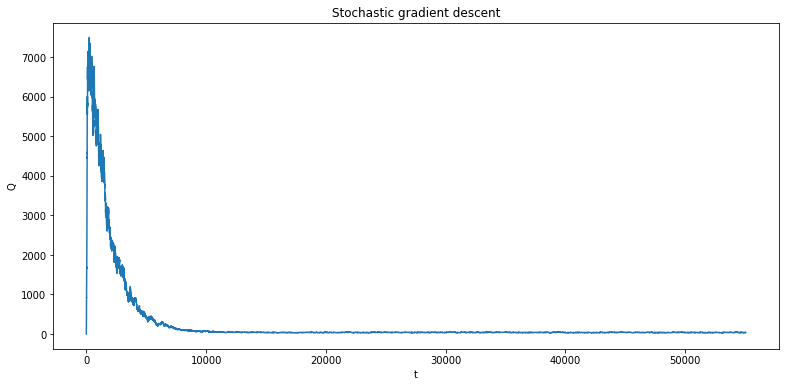

In [15]:
# Визуализируем изменение весов (красной точкой обозначены истинные веса, сгенерированные вначале)
plt.figure(figsize=(13, 6))
plt.title('Stochastic gradient descent')
plt.xlabel('t')
plt.ylabel('Q')

plt.plot(Q)



plt.show()

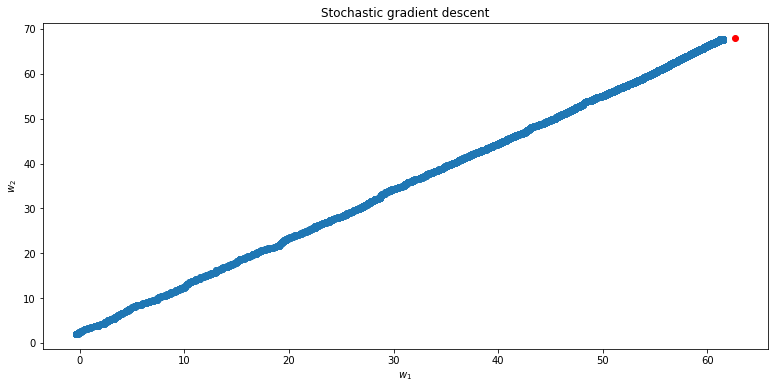

In [16]:
# Визуализируем изменение весов (красной точкой обозначены истинные веса, сгенерированные вначале)
plt.figure(figsize=(13, 6))
plt.title('Stochastic gradient descent')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')

plt.scatter(w_list[:, 0], w_list[:, 1])
plt.scatter(coef[0], coef[1], c='r')
# plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

#### Среднеквадратичная ошибка для обоих методов на одном графике

Text(0, 0.5, 'MSE')

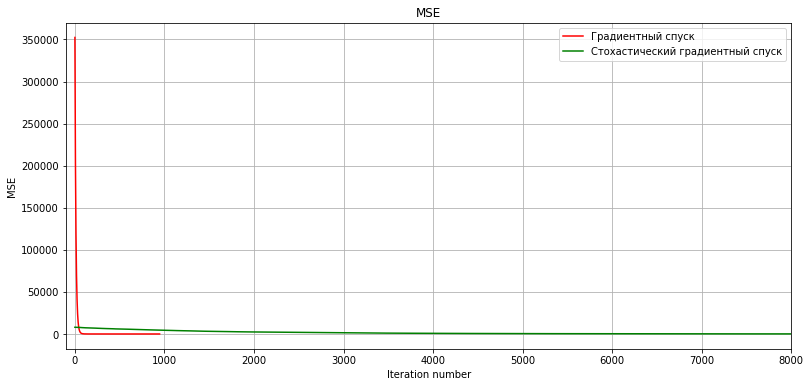

In [17]:
# Визуализируем изменение функционала ошибки
plt.figure(figsize=(13, 6))
plt.xlim((-100, 8000))
plt.plot(range(len(errors_GD)), errors_GD, c='r', label = 'Градиентный спуск')
plt.plot(range(len(errors_SGD)), errors_SGD, c='g', label = 'Стохастический градиентный спуск')
plt.legend(loc='upper right')
plt.grid(True)
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')

### Вывод по скорости сходимости

Получается, что градиентный спуск выдаёт большую ошибку в самом начале, но затем очень быстро сводит её к нулю. Стохастический градиентный спуск же изначально даёт очень маленькую (по сравнению с ГС) ошибку, но к нулю сводит её гораздо медленнее, т.е. через большее кол-во итераций.